## Image generation Artifacts

This notebook generated the images showing the example artifacts.
This includes the single artifacts in chapter 2 and the dataset sample examples in chapter 4.

In [ ]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append('../artitect/')

In [2]:
import pickle
from itertools import repeat
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from pytorch_lightning import seed_everything
import pytorch_lightning as pl
from artifact import Saw, Saw_centered

seed_everything(42, workers=True)


/opt/miniconda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 42


42

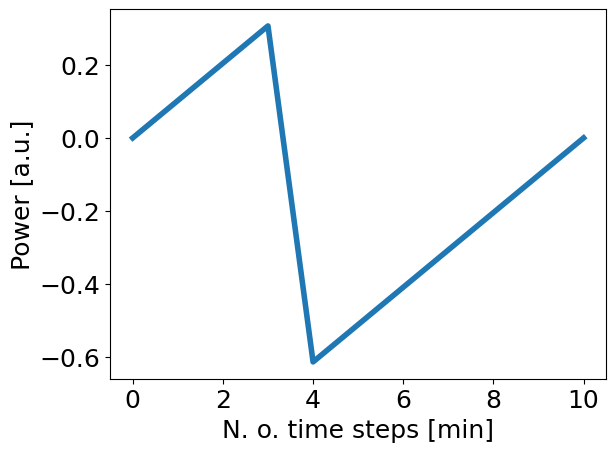

In [3]:
import matplotlib.pyplot as plt

artifact = Saw_centered()

a = artifact.generate()
plt.rcParams.update({'font.size': 18})
plt.plot(a[0], linewidth = 4)
plt.xlabel('N. o. time steps [min]') 
plt.ylabel("Power [a.u.]")
plt.show()

In [4]:
width = 512

"""
returns: list of list of arrays containing the time series in the datasets in names
    only adds the series that are longer than the provided width (512)
returns: weights for the time series in the list according to number of time series in the dataset
    so that in the datasets all datasets are sampled at the same rate
"""
def load_series(names: list[str], split: str, path: str):
    series: list[np.ndarray] = list()
    counts: list[float] = list()
    for name in names:
        with open(f"{path}/{name}_{split}.pickle", "rb") as f:
            raw = [a for a in pickle.load(f) if len(a) > width]
            series.extend(np.array(a).astype(np.float32) for a in raw)
            counts.extend(repeat(1 / len(raw), len(raw)))
    counts = np.array(counts)
    return series, np.divide(counts, np.sum(counts))


In [5]:
# Datasets for the thesis plots
# AuElDe, AuElDe_weights = load_series(["australian_electricity_demand_dataset"], "TRAIN", path="../data/processed")
# ElLo, ElLo_weights = load_series(["electricity_load_diagrams"], "TRAIN", path="../data/processed")

# datasets used here that need less storage
AuElDe, AuElDe_weights = load_series(["SemgHandGenderCh2"], "TRAIN", path="../data/processed")
ElLo, ElLo_weights = load_series(["PigCVP"], "TRAIN", path="../data/processed")

In [6]:
# TODO: how long is the width of an artifact in the real data?
# How "big" are the artifacts compared to the surrounding data?
from data import RealisticArtifactDataset, CenteredArtifactDataset, CachedArtifactDataset

AuElDe_mask_dataset = RealisticArtifactDataset(AuElDe,
                          Saw(),
                          width=width,
                          padding=64,
                          weight=AuElDe_weights)

ElHo_mask_dataset = RealisticArtifactDataset(ElLo,
                          Saw(),
                          width=width,
                          padding=64,
                          weight=ElLo_weights)

AuElDe_SW_dataset = CenteredArtifactDataset(AuElDe,
                          Saw_centered(),
                          width=width,
                          padding=64,
                          weight=AuElDe_weights,
                          p_has_artifact=1)

ElHo_SW_dataset = CenteredArtifactDataset(ElLo,
                          Saw_centered(),
                          width=width,
                          padding=64,
                          weight=ElLo_weights,
                          p_has_artifact=1)

In [7]:
from torch.utils.data import DataLoader

AuElDe_mask_loader = DataLoader(AuElDe_mask_dataset, batch_size=32)
AuElDe_SW_loader = DataLoader(AuElDe_SW_dataset, batch_size=32)
ElHo_mask_loader = DataLoader(ElHo_mask_dataset, batch_size=32)
ElHo_SW_loader = DataLoader(ElHo_SW_dataset, batch_size=32)

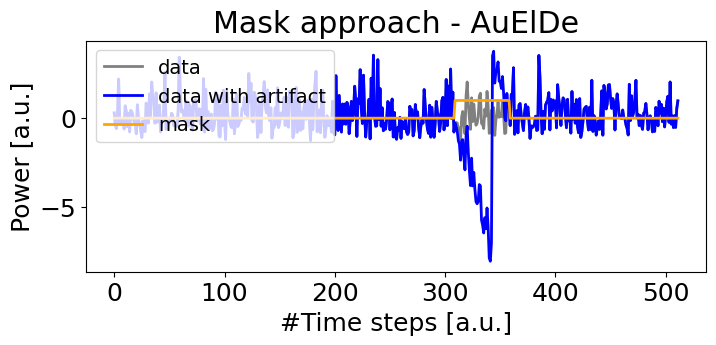

In [8]:
AuElDe_mask_sample = next(iter(AuElDe_mask_loader))
AuElDe_mask_sample = next(iter(AuElDe_mask_loader))
sample = AuElDe_mask_sample
plt.figure(figsize=(8, 3))
plt.plot(sample["data"][0], label="data", linewidth=2.0, color="grey")
plt.plot(sample["data"][0] + sample["artifact"][0], label="data with artifact", linewidth=2.0, color="blue")
plt.plot(sample["mask"][0], label="mask", linewidth=2.0, color="orange")

plt.title("Mask approach - AuElDe")
plt.xlabel("#Time steps [a.u.]")
plt.ylabel("Power [a.u.]")
plt.rcParams.update({'font.size': 14})

plt.legend(loc=2)
plt.show(block=True)

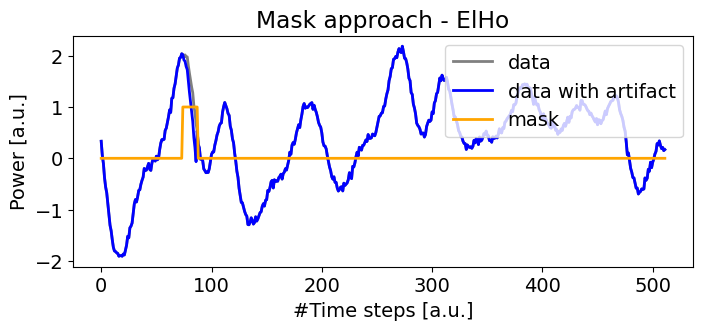

In [9]:
ElHo_mask_sample = next(iter(ElHo_mask_loader))
sample = ElHo_mask_sample
plt.figure(figsize=(8, 3))
plt.plot(sample["data"][0], label="data", linewidth=2.0, color="grey")
plt.plot(sample["data"][0] + sample["artifact"][0], label="data with artifact", linewidth=2.0, color="blue")
plt.plot(sample["mask"][0], label="mask", linewidth=2.0, color="orange")

plt.title("Mask approach - ElHo")
plt.xlabel("#Time steps [a.u.]")
plt.ylabel("Power [a.u.]")
plt.rcParams.update({'font.size': 14})

plt.legend(loc=1)
plt.show(block=True)

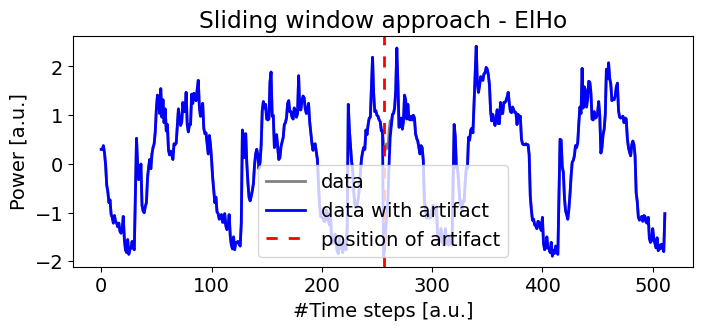

In [24]:
ElHo_SW_sample = next(iter(ElHo_SW_loader))
sample = ElHo_SW_sample
plt.figure(figsize=(8, 3))
plt.plot(sample["data"][0], label="data", linewidth=2.0, color="grey")
plt.plot(sample["data"][0] + sample["artifact"][0], label="data with artifact", linewidth=2.0, color="blue")
plt.axvline(x=256, c="red", linestyle="--", linewidth=2.0, dashes=(4,4), label="position of artifact")

plt.title("Sliding window approach - ElHo")
plt.xlabel("#Time steps [a.u.]")
plt.ylabel("Power [a.u.]")
plt.rcParams.update({'font.size': 14})

plt.legend()
plt.show(block=True)

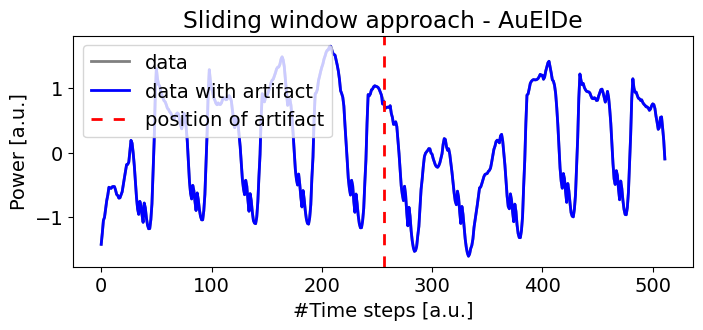

In [25]:
AuElDe_SW_sample = next(iter(AuElDe_SW_loader))
sample = AuElDe_SW_sample
plt.figure(figsize=(8, 3))
plt.plot(sample["data"][0], label="data", linewidth=2.0, color="grey")
plt.plot(sample["data"][0] + sample["artifact"][0], label="data with artifact", linewidth=2.0, color="blue")
plt.axvline(x=256, c="red", linestyle="--", linewidth=2.0, dashes=(4,4), label="position of artifact")

plt.title("Sliding window approach - AuElDe")
plt.xlabel("#Time steps [a.u.]")
plt.ylabel("Power [a.u.]")
plt.rcParams.update({'font.size': 14})

plt.legend(loc=2)
plt.show(block=True)